In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics.pairwise import cosine_similarity
from typing import List

### Data Load

In [2]:
data_path = "./data/anime/"

animes = pd.read_csv(data_path+"anime.csv")
ratings = pd.read_csv(data_path+"rating.csv")

<hr>

In [3]:
display(animes.sample(10))

,anime_id,name,genre,type,episodes,rating,members
8136,33108,Anime Douyou,"Kids, Music",Music,Unknown,5.75,38
693,9734,K-On!!: Keikaku!,"Comedy, Music, School, Slice of Life",Special,1,7.89,50496
8749,22953,Hana no Zundamaru: Junk,"Comedy, Martial Arts, Parody",ONA,3,3.96,96
3982,30379,Nagato Yuki-chan no Shoushitsu: Owarenai Natsu...,"Comedy, Seinen, Slice of Life",OVA,1,6.83,9773
246,3167,Eve no Jikan,"Sci-Fi, Slice of Life",ONA,6,8.26,99074
2296,31500,High School Fleet,"Action, Military, School",TV,12,7.30,38646
2317,30205,Aoharu x Kikanjuu,"Action, Comedy, Shounen, Sports",TV,12,7.29,97674
8438,23189,Dekoboko Shin Gachou: Meian no Shippai,Comedy,Movie,1,7.08,102
5525,7598,Loups=Garous,"Mystery, Sci-Fi, Thriller",Movie,1,6.43,12350
9550,31582,Mimizu Monogatari,Dementia,Movie,1,3.39,139


In [4]:
animes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [5]:
animes.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

<hr>

In [6]:
display(ratings.sample(10))

,user_id,anime_id,rating
3878034,36405,5081,8
1771387,17149,23281,5
5941434,55501,6747,7
1761503,17082,1535,-1
6183881,57834,76,6
6458994,59700,609,5
7043420,65805,1015,9
4190345,39723,225,-1
5706688,53501,849,10
7504843,70185,10793,7


In [7]:
ratings.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

### Preprocessing & Feature Engineering

#### Feature Extract & remove nan data

In [8]:
# 사용하려는 feature만 추출
animes = animes[['anime_id', 'type', 'rating', 'members', 'name', 'genre']]
# 칼럼명 변경
animes.columns = ['anime_id', 'type', 'anime_total_rating', 'members', 'name', 'genre']
# 결측값이 포함된 애니는 drop
animes = animes.dropna()

In [9]:
animes

,anime_id,type,anime_total_rating,members,name,genre
0,32281,Movie,9.37,200630,Kimi no Na wa.,"Drama, Romance, School, Supernatural"
1,5114,TV,9.26,793665,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili..."
2,28977,TV,9.25,114262,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S..."
3,9253,TV,9.17,673572,Steins;Gate,"Sci-Fi, Thriller"
4,9969,TV,9.16,151266,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S..."
...,...,...,...,...,...,...
12289,9316,OVA,4.15,211,Toushindai My Lover: Minami tai Mecha-Minami,Hentai
12290,5543,OVA,4.28,183,Under World,Hentai
12291,5621,OVA,4.88,219,Violence Gekiga David no Hoshi,Hentai
12292,6133,OVA,4.98,175,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai


<hr>

In [10]:
# 평점 테이블도 동일하게 처리, 무효한 값은 제거 (rating이 -1인 값)
ratings = ratings[['user_id', 'anime_id', 'rating']]
ratings = ratings[ratings['rating']!=-1] # 

In [11]:
ratings

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


<hr>

#### Data Merge

In [12]:
data = ratings.merge(animes, on="anime_id", how="inner")

In [13]:
data

,user_id,anime_id,rating,type,anime_total_rating,members,name,genre
0,1,8074,10,TV,7.46,535892,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural"
1,3,8074,6,TV,7.46,535892,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural"
2,5,8074,2,TV,7.46,535892,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural"
3,12,8074,6,TV,7.46,535892,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural"
4,14,8074,6,TV,7.46,535892,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural"
...,...,...,...,...,...,...,...,...
6337141,69964,23585,7,Special,6.14,138,Haha wo Tazunete Sanzenri Specials,"Adventure, Drama, Slice of Life"
6337142,69964,33659,6,Special,5.15,444,Fushigi na Somera-chan Special,"Comedy, Magic, Slice of Life"
6337143,72800,30738,4,Movie,5.55,185,Gamba: Gamba to Nakama-tachi,"Adventure, Kids"
6337144,73135,8723,5,OVA,5.84,264,Anime Rakugo Kan,Comedy


#### User data extract
- user 정보가 없으므로, 유저의 평점 패턴에서 유저 feature 추출

In [14]:
user_avg_ratings = data.groupby("user_id")['rating'].mean().rename('User-AvgRating') # 유저가 전반적으로 평점을 얼마나 주었는지
user_num_ratings = data.groupby("user_id")["rating"].count().rename("User-NumRating") #  유저가 몇 개의 평가를 했는지

In [15]:
user_avg_ratings

user_id
1        10.000000
2        10.000000
3         7.565217
5         4.355120
7         7.387755
           ...    
73512     8.583333
73513     7.515152
73514    10.000000
73515     8.547486
73516     9.000000
Name: User-AvgRating, Length: 69600, dtype: float64

In [16]:
user_num_ratings

user_id
1          4
2          1
3         92
5        459
7        343
        ... 
73512     12
73513     33
73514      1
73515    179
73516      2
Name: User-NumRating, Length: 69600, dtype: int64

<hr>

In [17]:
# 추출한 유저 피처 결합
user_features = pd.concat([user_avg_ratings, user_num_ratings], axis=1)
user_features

,User-AvgRating,User-NumRating
user_id,,
1,10.000000,4
2,10.000000,1
3,7.565217,92
5,4.355120,459
7,7.387755,343
...,...,...
73512,8.583333,12
73513,7.515152,33
73514,10.000000,1


#### Extract the number of anim rated

In [18]:
# 애니 메타 데이터에서 아이템 관련 피쳐 수 생성
item_num_ratings = data.groupby('anime_id')['rating'].count().rename('Item-NumRatings')
item_num_ratings

anime_id
1        13449
5         5790
6         9385
7         2169
8          308
         ...  
34324       11
34325       15
34349        3
34367        4
34475        3
Name: Item-NumRatings, Length: 9892, dtype: int64

#### Extract TF-IDF feature using animation name

In [19]:
# 애니 이름 피처에서 TF-IDF 피쳐 생성, 총 10개의 이름 생성 (most frequent 10 words)
tfidf_vectorizer = TfidfVectorizer(max_features=10) # Stopword 처리 안함!
item_name_tfidf = tfidf_vectorizer.fit_transform(animes['name']).toarray()
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_feature_names

array(['chan', 'ga', 'movie', 'ni', 'no', 'special', 'specials', 'the',
       'to', 'wa'], dtype=object)

In [20]:
tf_idf_df = pd.DataFrame(item_name_tfidf, columns=tfidf_feature_names, index=animes.anime_id)
tf_idf_df

,chan,ga,movie,ni,no,special,specials,the,to,wa
anime_id,,,,,,,,,,
32281,0.0,0.0,0.0,0.0,0.450828,0.0,0.0,0.0,0.0,0.892611
5114,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
28977,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
9253,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
9969,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
9316,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
5543,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
5621,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000


#### One-Hot-Encoding

In [21]:
ohe = OneHotEncoder(sparse=False)
item_type_ohe = ohe.fit_transform(animes[['type']])

In [22]:
item_type_ohe

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [23]:
type_df = pd.DataFrame(item_type_ohe, columns=[f'Type-{cat}' for cat in ohe.categories_[0]], index=animes.anime_id)
type_df

,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV
anime_id,,,,,,
32281,1.0,0.0,0.0,0.0,0.0,0.0
5114,0.0,0.0,0.0,0.0,0.0,1.0
28977,0.0,0.0,0.0,0.0,0.0,1.0
9253,0.0,0.0,0.0,0.0,0.0,1.0
9969,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
9316,0.0,0.0,0.0,1.0,0.0,0.0
5543,0.0,0.0,0.0,1.0,0.0,0.0
5621,0.0,0.0,0.0,1.0,0.0,0.0


#### Data Merge
- Item fetures

In [24]:
animes_features = animes[['anime_id', 'members', 'anime_total_rating']]

In [25]:
item_features = pd.DataFrame(item_num_ratings).merge(tf_idf_df, on="anime_id") \
                                              .merge(type_df, on="anime_id") \
                                              .merge(animes_features.set_index("anime_id"), on="anime_id")

In [26]:
item_features

,Item-NumRatings,chan,ga,movie,ni,no,special,specials,the,to,wa,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV,members,anime_total_rating
anime_id,,,,,,,,,,,,,,,,,,,
1,13449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,486824,8.82
5,5790,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,137636,8.40
6,9385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,283069,8.32
7,2169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,64905,7.36
8,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9848,7.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,817,5.40
34325,15,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1454,7.05
34349,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1885,7.25


<hr>

- 인터렉션 데이터와 함께, user 및 item 피처 결합

In [27]:
# 인터렉션 데이터와 함께, user 및 item 피처 결합
data = data.drop(['anime_total_rating', 'members'], axis=1)
data = data.join(user_features, on='user_id')
data = data.merge(item_features, on='anime_id')

In [28]:
data

,user_id,anime_id,rating,type,name,genre,User-AvgRating,User-NumRating,Item-NumRatings,chan,...,to,wa,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV,members,anime_total_rating
0,1,8074,10,TV,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",10.000000,4,19488,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,535892,7.46
1,3,8074,6,TV,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",7.565217,92,19488,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,535892,7.46
2,5,8074,2,TV,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",4.355120,459,19488,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,535892,7.46
3,12,8074,6,TV,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",8.818182,22,19488,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,535892,7.46
4,14,8074,6,TV,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",7.195122,123,19488,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,535892,7.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6337141,69964,23585,7,Special,Haha wo Tazunete Sanzenri Specials,"Adventure, Drama, Slice of Life",7.891859,823,1,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,138,6.14
6337142,69964,33659,6,Special,Fushigi na Somera-chan Special,"Comedy, Magic, Slice of Life",7.891859,823,1,0.710672,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,444,5.15
6337143,72800,30738,4,Movie,Gamba: Gamba to Nakama-tachi,"Adventure, Kids",5.930159,315,1,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,185,5.55
6337144,73135,8723,5,OVA,Anime Rakugo Kan,Comedy,5.710953,986,1,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,264,5.84


#### Extract Implicit feature

In [29]:
# 유저의 평균 평점보다 높으면 1 아니면 0
data['rating'] = (data['rating'] > data['User-AvgRating']).astype(int)

### Model Train

#### Data Split

In [30]:
X = data.drop(columns=['user_id', 'anime_id', 'rating', 'type', 'name', 'genre'])
y = data['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
X_train.head() # user-meta, item-meta 정보 가짐

,User-AvgRating,User-NumRating,Item-NumRatings,chan,ga,movie,ni,no,special,specials,...,to,wa,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV,members,anime_total_rating
1509263,8.080645,62,5259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,151561,8.53
6271372,8.814085,355,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2718,7.65
1083815,8.647059,51,11399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,299278,7.14
2087798,7.522523,333,5697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,225927,8.50
2273893,8.625000,16,5318,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,117080,6.85


In [32]:
y_train.head()

1509263    1
6271372    1
1083815    0
2087798    1
2273893    1
Name: rating, dtype: int32

#### Model define

In [33]:
models = {
    "Decision Tree" : DecisionTreeClassifier(random_state=42),
    "Random Forest" : RandomForestClassifier(random_state=42),
    "LGBM" : LGBMClassifier(random_state=42)
}

#### Model Training

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

# 데이터셋 사이즈 지정
dataset_sizes = [1_000, 10_000, 100_000]

# 각 모델 별 auc score를 저장하기 위해 딕셔너리 정의
auc_scores = {model_name: [] for model_name in models.keys()}

# 각 모델 별 roc curve 정보 저장을 위해 딕셔너리 정의
roc_curves = {model_name: [] for model_name in models.keys()}

In [35]:
# ROC curve 그리기
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    # 대각선 추가
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)

In [36]:
# 각 모델 별 auc score를 저장하기 위해 딕셔너리 정의
auc_scores = {model_name: [] for model_name in models.keys()}

# 각 모델 별 roc curve 정보 저장을 위해 딕셔너리 정의
roc_curves = {model_name: [] for model_name in models.keys()}

# 데이터 사이즈별로 iteration
for size in dataset_sizes:
    # 각 사이즈별로 데이터를 샘플링함
    X_train_sample = X_train.sample(n=size, random_state=42)
    y_train_sample = y_train.loc[X_train_sample.index]

    # 모델 별로 반복
    for model_name, model in tqdm(models.items()):
        print(f"Training {model_name} with {size} samples...")
        
        # 모델 적합
        model.fit(X_train_sample, y_train_sample)

        # 예측 결과 생성
        y_pred = model.predict_proba(X_test)[:, 1]

        # AUC 점수 계산 
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores[model_name].append(auc_score)
        
        # ROC 곡선
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_curves[model_name].append((fpr, tpr))

        print(f"{model_name} AUC: {auc_score}")

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Training Decision Tree with 1000 samples...


 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.33it/s]

Decision Tree AUC: 0.5790152055467094
Training Random Forest with 1000 samples...


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:19<00:11, 11.41s/it]

Random Forest AUC: 0.6697099344821714
Training LGBM with 1000 samples...


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.33s/it]

LGBM AUC: 0.6630490124112162



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Training Decision Tree with 10000 samples...


 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.20it/s]

Decision Tree AUC: 0.5921858710130594
Training Random Forest with 10000 samples...


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:31<00:18, 18.64s/it]

Random Forest AUC: 0.6908664789528572
Training LGBM with 10000 samples...


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:34<00:00, 11.43s/it]


LGBM AUC: 0.7338520630193772


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Training Decision Tree with 100000 samples...


 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.74s/it]

Decision Tree AUC: 0.5915011555575909
Training Random Forest with 100000 samples...


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:54<00:31, 31.80s/it]

Random Forest AUC: 0.6955666973472181
Training LGBM with 100000 samples...


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:57<00:00, 19.08s/it]

LGBM AUC: 0.7494532231520109


### Evaluate

In [37]:
print(auc_scores)

{'Decision Tree': [0.5790152055467094, 0.5921858710130594, 0.5915011555575909], 'Random Forest': [0.6697099344821714, 0.6908664789528572, 0.6955666973472181], 'LGBM': [0.6630490124112162, 0.7338520630193772, 0.7494532231520109]}


Decision Tree [0.5790152055467094, 0.5921858710130594, 0.5915011555575909]
Random Forest [0.6697099344821714, 0.6908664789528572, 0.6955666973472181]
LGBM [0.6630490124112162, 0.7338520630193772, 0.7494532231520109]


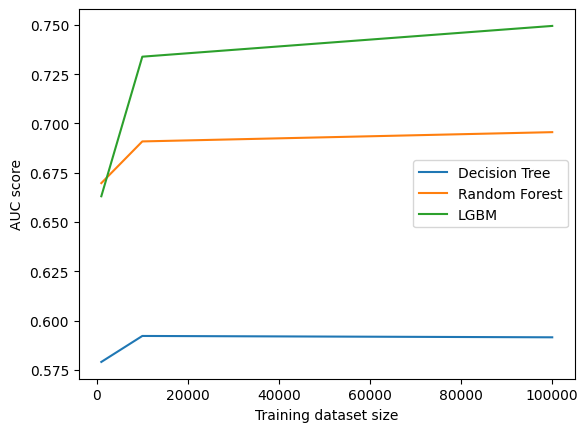

In [38]:
# AUC 스코어 시각화
for model_name, model_auc_scores in auc_scores.items():
    print(model_name, model_auc_scores)
    plt.plot(dataset_sizes, model_auc_scores, label=model_name)
    
plt.xlabel('Training dataset size')
plt.ylabel('AUC score')
plt.legend()
plt.show()

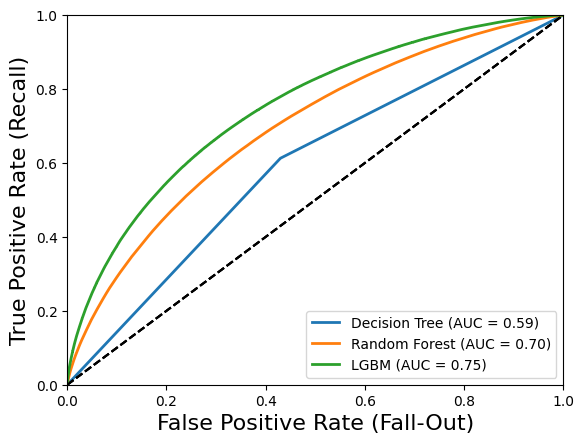

In [39]:
# 가장 큰 데이터셋에 대해서, ROC 커브 그리기
for model_name, model_roc_curves in roc_curves.items():
    fpr, tpr = model_roc_curves[-1]  # Select the ROC curve for the largest dataset size
    plot_roc_curve(fpr, tpr, label=f"{model_name} (AUC = {auc_scores[model_name][-1]:.2f})")
plt.legend()
plt.show()

#### 실제 예측값 확인

In [40]:
user_id = 20

In [41]:
user_data = data[data['user_id'] == user_id]
rated_animes = user_data['anime_id'].unique()
unrated_animes = item_features[~item_features.index.isin(rated_animes)]

In [42]:
# 유저 정보 붙여주기
user_features_df = user_features.loc[user_id]
unrated_animes = unrated_animes.assign(**user_features_df)


user_features_df.head()

User-AvgRating     9.578947
User-NumRating    19.000000
Name: 20, dtype: float64

In [43]:
unrated_animes.assign(**user_features_df)

,Item-NumRatings,chan,ga,movie,ni,no,special,specials,the,to,...,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV,members,anime_total_rating,User-AvgRating,User-NumRating
anime_id,,,,,,,,,,,,,,,,,,,,,
1,13449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,486824,8.82,9.578947,19.0
5,5790,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,137636,8.40,9.578947,19.0
6,9385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,283069,8.32,9.578947,19.0
7,2169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,64905,7.36,9.578947,19.0
8,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,9848,7.06,9.578947,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,817,5.40,9.578947,19.0
34325,15,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1454,7.05,9.578947,19.0
34349,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1885,7.25,9.578947,19.0


In [44]:
def recommend_top_n(user_id, model, n=5):
    # 아직 유저가 평가하지 않은 애니 가져오기
    user_data = data[data['user_id'] == user_id]
    rated_animes = user_data['anime_id'].unique()
    unrated_animes = item_features[~item_features.index.isin(rated_animes)]
    
    # 유저 정보 붙여주기
    user_features_df = user_features.loc[user_id]
    unrated_animes = unrated_animes.assign(**user_features_df)

    # 해당 유저 대상으로 모델 예측
    unrated_animes['predicted_rating'] = model.predict_proba(unrated_animes)[:, 1]

    # 상위 N개의 평점 예측
    top_n_animes = unrated_animes.sort_values('predicted_rating', ascending=False).head(n)

    return top_n_animes

In [45]:
# 특정 유저에 대한 상위 n개 예측 생성
user_id = 26
top_n = recommend_top_n(user_id, models['LGBM'], n=5)[['predicted_rating']]

# top n개 예측의 상세 정보
top_n_details = top_n.merge(animes, how='left', left_index=True, right_on='anime_id')

print(f'Top 5 anime recommendations for user {user_id}:')
display(top_n_details)

Top 5 anime recommendations for user 26:


,predicted_rating,anime_id,type,anime_total_rating,members,name,genre
5279,0.376144,31530,Special,6.50,2738,Classroom☆Crisis Special,"School, Sci-Fi"
6276,0.376144,22031,Special,6.19,370,Samurai Gun Special,"Action, Historical, Seinen"
5533,0.302538,31750,OVA,6.43,485,TV-ban Pokemon Special Masara Town-hen Soushuuhen,"Action, Adventure, Comedy, Fantasy, Kids"
3313,0.295702,33491,OVA,7.03,2480,Shounen Maid Special,"Comedy, Shoujo, Slice of Life"
7030,0.295702,5647,OVA,5.78,526,Doukyuusei 2 (OVA) Special: Sotsugyousei,"Ecchi, Harem, School"


In [46]:
def recommend_top_n(user_id, mode, n=5):
    #  아직 user가 평가하지 않은 애니 데이터 가지고 오기
    user_data = data[data['user_id']==user_id]
    rated_animes = user_data['anime_id'].unique()
    unrated_animes = item_features[~item_features.index.isin(rated_animes)]
    
    # User 정보 붙여주기
    user_features_df = user_features.loc[user_id]
    unrated_animes = unrated_animes.assign(**user_feature_df)
    
    # 해당 유저 대상으로 모델 예측
    unrated_animes['predicted_rating'] = model.predict_proba(unrated_animes)[:, 1]
    
    #  상위 N개의 평점 예측
    top_n_animes = unrated_animes.sort_values('predicted_rating', ascending=False).head(n)
    
    return top_n_animes

In [47]:
# 좋은 평점을 준 애니 검색
user_ratings = ratings[ratings['user_id'] == user_id]
well_rated_animes = user_ratings[user_ratings['rating'] >= user_ratings['rating'].mean()]

# 상세 정보 조회
well_rated_details = animes[animes['anime_id'].isin(well_rated_animes['anime_id'])]

# 평점 정보를 포함한 좋은 평점 정보 출력
well_rated_details = well_rated_details.merge(well_rated_animes[['anime_id', 'rating']], on='anime_id', how='inner')


In [48]:
print(f'\nWell-rated animes by user {user_id}:')
display(well_rated_details)


Well-rated animes by user 26:


,anime_id,type,anime_total_rating,members,name,genre,rating
0,8525,TV,7.95,284846,Kami nomi zo Shiru Sekai,"Comedy, Harem, Romance, Shounen, Supernatural",10
1,10793,TV,7.81,460959,Guilty Crown,"Action, Drama, Sci-Fi, Super Power",10


### Feature Importance

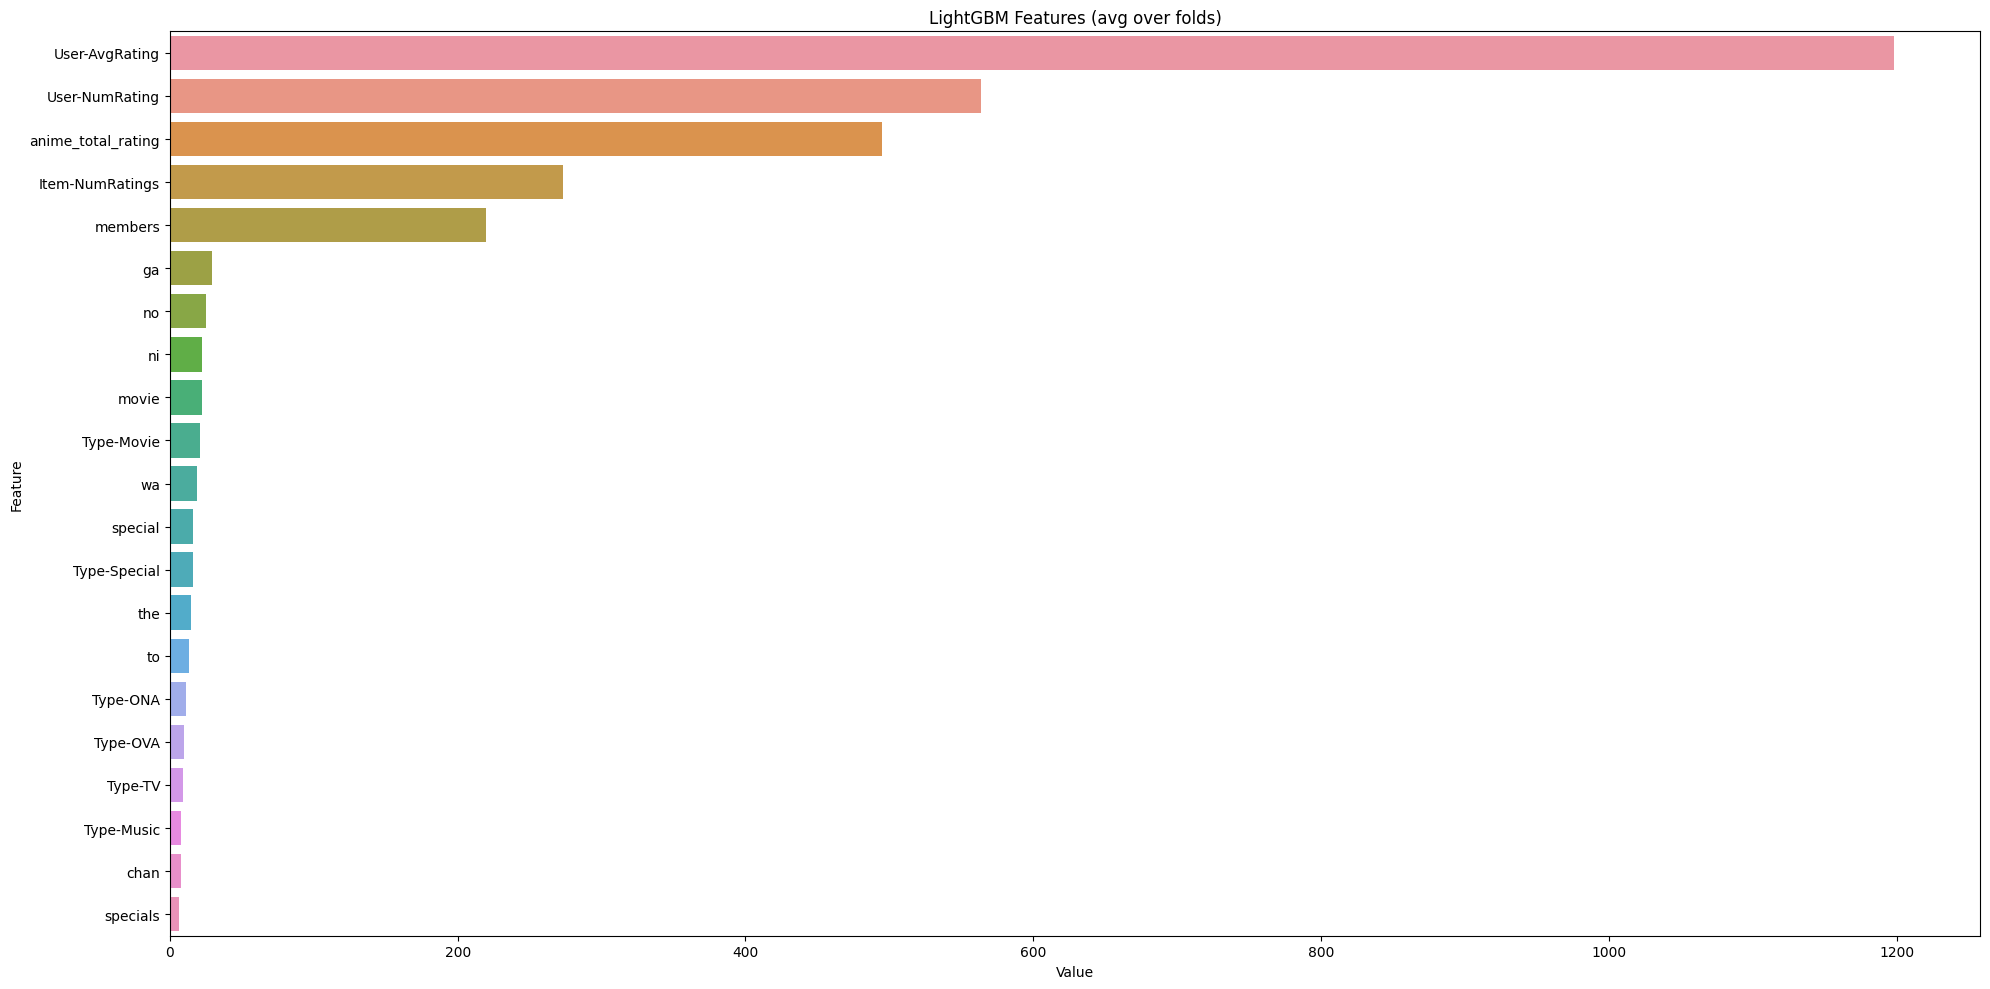

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# model = models['lgbm']

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()